In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests as re
import urllib3

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score

from datetime import datetime
from datetime import timedelta

Using TensorFlow backend.


```python
# For use on Google collab
url_train   = 'https://raw.githubusercontent.com/chattrapatchua/dsi10_project4/master/data/train.csv'
url_test    = 'https://raw.githubusercontent.com/chattrapatchua/dsi10_project4/master/data/test.csv'
url_weather = 'https://raw.githubusercontent.com/chattrapatchua/dsi10_project4/master/data/weather.csv'
url_spray   = 'https://raw.githubusercontent.com/chattrapatchua/dsi10_project4/master/data/spray.csv'

train   = pd.read_csv(url_train)
test    = pd.read_csv(url_test)
weather = pd.read_csv(url_weather)
spray   = pd.read_csv(url_spray)
```

# Problem Statement

To develop a predictive model that will forecast the probability of WNV presence in 138 mosquito traps around Chicago over the course of a season. WNV is a communicable disease that is spread through its most common vector, mosquitoes.

# Executive Summary

- Data cleaning and EDA done on the train/test, weather and spray datasets
    - Train.csv was split into a training set and testing set. EDA was done on the training set.
- General observed trends:
    - WNV incidences spiked in July and August, the summer months in Chicago.
    - The spikes corresponds with increase in temp. and also humidity.
    - During the summer months, the number of days between rain days generally increases as well.
- Visualization of spatial data was done to observe the trap locations, concentration of WNV incidences, and spray locations.
    - It was found that O'Hare Airport was a major hotspot, with the other hotspot being in the River Grove/Belmont Terrace area. These areas either have multiple bodies of water, or are areas with a lot of greenery.
- Cost-benefit analysis done for spraying pesticide. It was concluded that usage of pesticide was not worth the amount of money for the effect it created.
- Modelling was done with various classification models, with the best being an XGBoost model.

# Data Dictionary

|Feature|Type|Usage in model|Description|
|-------|----|-----|-----------|
|WnvPresent|*int*|Target Variable|The target variable; whether the sample contains WNV (1) or not (0)|
|Longitude, Latitude|*float*|Predictor Variable|Coordinates of the location of the traps|  
|Tavg|*float*|Predictor Variable|Avg. temperature on that day|
|Tavg_rolling|*float*|Predictor Variable|3, 7, 14 days rolling avgs. for Tavg|
|DewPoint|*float*|Predictor Variable|A measure of the humidity|
|DewPoint_rolling|*float*|Predictor Variable|3, 7, 14 days rolling avgs. for Tavg|
|Days_since_rain|*int*|Predictor Variable|The number of days since a rain day|

# Import data

In [2]:
#Import the datasets to be used for this project
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
weather = pd.read_csv("./data/weather.csv")
spray = pd.read_csv("./data/spray.csv")

# 1. Data Cleaning & EDA

## 1.1 Train & test dataset

### Train

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [4]:
train.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


- 12 features
- Approx. 10,000 samples

In [5]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,29/5/2007,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,29/5/2007,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,29/5/2007,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,29/5/2007,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,29/5/2007,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


### Test

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
Id                        116293 non-null int64
Date                      116293 non-null object
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null int64
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [7]:
test.describe()

,Id,Block,Latitude,Longitude,AddressAccuracy
count,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000
mean,58147.000000,41.131100,41.849389,-87.693658,7.954357
std,33571.041765,24.864726,0.106593,0.080699,1.252733
min,1.000000,10.000000,41.644612,-87.930995,3.000000
25%,29074.000000,18.000000,41.753411,-87.750938,8.000000
50%,58147.000000,39.000000,41.862292,-87.694991,8.000000
75%,87220.000000,61.000000,41.951866,-87.648860,9.000000
max,116293.000000,98.000000,42.017430,-87.531635,9.000000


- 11 features (no NumMosquitos feature)
- Approx. 110k samples

In [8]:
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


### Data Cleaning

#### Dropping features

In [9]:
# Drop NumMosquitos feature as it is not present in test.csv
train.drop(columns='NumMosquitos', inplace=True)

In [10]:
train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'WnvPresent'],
      dtype='object')

In [11]:
# Address, Block, Street, AddressNumberAndStreet, AddressAccuracy, Trap can all be dropped
# These features are string data type, and give location based info.
# Location info. can be obtained through Latitude and Longitude
train.drop(columns=['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], inplace=True)

# Drop whatever was dropped for train.csv
test.drop(columns=['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], inplace=True)

In [12]:
# # 'Trap' is just the code of the trap, which is also the location
# # Since there is numerical data for the location, trap can be dropped
train.drop(columns=['Trap'], inplace=True)
test.drop(columns=['Trap'], inplace=True)

In [13]:
test.head()

,Id,Date,Species,Latitude,Longitude
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991
1,2,2008-06-11,CULEX RESTUANS,41.95469,-87.800991
2,3,2008-06-11,CULEX PIPIENS,41.95469,-87.800991
3,4,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991
4,5,2008-06-11,CULEX TERRITANS,41.95469,-87.800991


#### Changing data type

In [14]:
# Date feature is a string
# Change to date-time type
train['Date'] = pd.to_datetime(train['Date'], dayfirst=True, format='%d/%m/%Y')
test['Date'] = pd.to_datetime(test['Date'], yearfirst=True, format='%Y-%m-%d')

In [15]:
train.head()

,Date,Species,Latitude,Longitude,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,0
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,0


In [16]:
test.head()

,Id,Date,Species,Latitude,Longitude
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991
1,2,2008-06-11,CULEX RESTUANS,41.95469,-87.800991
2,3,2008-06-11,CULEX PIPIENS,41.95469,-87.800991
3,4,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991
4,5,2008-06-11,CULEX TERRITANS,41.95469,-87.800991


In [17]:
# Check to see if conversion was done correctly
# There was an issue with inconsistent parsing of the string 
train['Date'].dt.month.unique()

array([ 5,  6,  7,  8,  9, 10], dtype=int64)

In [18]:
test['Date'].dt.month.unique()

array([ 6,  7,  8,  9, 10], dtype=int64)

- Datetime conversion seems correct
- train.csv has data for only May to Oct
- test.csv has data for only Jun to Oct

### Splitting train.csv to training & testing set

In [19]:
# Split train.csv to training_set and testing_set
X = train[['Date', 'Species', 'Latitude', 'Longitude']]
y = train['WnvPresent']
X_training, X_testing, y_training, y_testing = train_test_split(X, y, stratify=y, random_state=55)

In [20]:
# Check out dimension for X_training
X_training.shape

(7879, 4)

### Preliminary EDA on training set

In [21]:
# Merge X_training and y_training for EDA
training = X_training.join(y_training)

- **Baseline**

In [22]:
# Get baseline accuracy score for predicting absence of virus
training['WnvPresent'].value_counts(normalize=True)

0    0.947582
1    0.052418
Name: WnvPresent, dtype: float64

- Baseline accuracy score for predicting absence of WNV is 94.76%
- It can be seen that this is a dataset with highly unbalanced classes.
- SMOTE will be used later on to deal with this oversampling issue.


- **WNV cases across time periods**

Text(0.5, 0, 'Year')

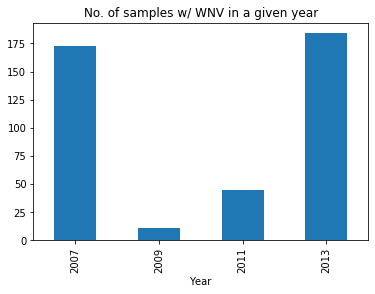

In [23]:
# See the number of WNV cases across year
ax = training.groupby(train['Date'].dt.year).sum()['WnvPresent'].plot(kind='bar')
ax.set_title('No. of samples w/ WNV in a given year')
ax.set_xlabel('Year')

Inference:
- 2007 & 2013 were the years with highest number  of samples found w/ WNV
- 2011 was the year with least

Text(0.5, 1.0, 'No. of samples w/ WNV in a given (year, month)')

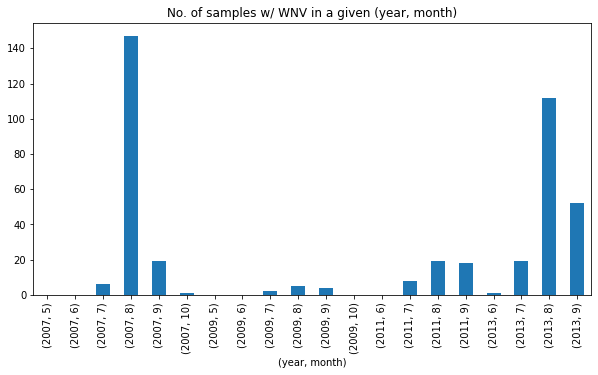

In [24]:
# See the number of WNV samples across months
ax = training.groupby([training['Date'].dt.year, training['Date'].dt.month]).sum()['WnvPresent'].plot(kind='bar', figsize=(10,5))
ax.set_xlabel('(year, month)')
ax.set_title('No. of samples w/ WNV in a given (year, month)')

Inference:
- Across the time period, July, August seems to have had the highest numbers of WNV carriers.
- July and August are the summer months for Chicago (https://www.tripsavvy.com/best-time-to-visit-chicago-4175898)

- **Species of mosquito and relation to WNV**

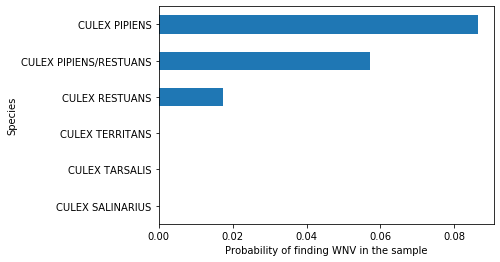

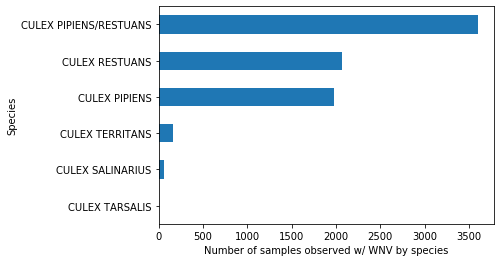

In [25]:
# Get a sense of the various species of mosquitos
# Some species could be carriers of the virus
ax = training.groupby('Species').mean()['WnvPresent'].sort_values(ascending=True).plot(kind='barh')
ax.set_xlabel('Probability of finding WNV in the sample')
plt.show()
ax = training.groupby('Species').count()['WnvPresent'].sort_values(ascending=True).plot(kind='barh')
ax.set_xlabel('Number of samples observed w/ WNV by species')
plt.show()

Inference:
- Culex Pipiens/Restuans species have highest probability of carrying WNV in Chicago.
- However, research shows that all of the CULEX species sub-types are carriers of WNV (https://en.wikipedia.org/wiki/West_Nile_virus), therefore Species will be dropped later as it gives wrong inference about the carrier population.

## 1.2 Weather dataset

In [26]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


In [27]:
weather.describe()

,Station,Tmax,Tmin,DewPoint,ResultSpeed,ResultDir
count,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000
mean,1.500000,76.166101,57.810462,53.457880,6.960666,17.494905
std,0.500085,11.461970,10.381939,10.675181,3.587527,10.063609
min,1.000000,41.000000,29.000000,22.000000,0.100000,1.000000
25%,1.000000,69.000000,50.000000,46.000000,4.300000,7.000000
50%,1.500000,78.000000,59.000000,54.000000,6.400000,19.000000
75%,2.000000,85.000000,66.000000,62.000000,9.200000,25.000000
max,2.000000,104.000000,83.000000,75.000000,24.100000,36.000000


In [28]:
pd.set_option('max_columns', 500)
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,1/5/2007,83,50,67,14,51,56,0,2,448,1849,,0,M,0,0,29.1,29.82,1.7,27,9.2
1,2,1/5/2007,84,52,68,M,51,57,0,3,-,-,,M,M,M,0,29.18,29.82,2.7,25,9.6
2,1,2/5/2007,59,42,51,-3,42,47,14,0,447,1850,BR,0,M,0,0,29.38,30.09,13.0,4,13.4
3,2,2/5/2007,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0,29.44,30.08,13.3,2,13.4
4,1,3/5/2007,66,46,56,2,40,48,9,0,446,1851,,0,M,0,0,29.39,30.12,11.7,7,11.9


### Data Cleaning

In [29]:
# Change Date to date-time data type
#weather['Date'] = pd.to_datetime(weather['Date'])
#weather['Date'] = weather['Date'].dt.strftime('%d/%m/%Y')
#weather['Date'] = pd.to_datetime(weather['Date'])
weather['Date'] = pd.to_datetime(weather['Date'], dayfirst=True, format='%d/%m/%Y')

In [30]:
weather.tail()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
2939,2,2014-10-29,49,40,45,M,34,42,20,0,-,-,,M,M,M,0,29.42,30.07,8.5,29,9
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,622,1649,,0,M,0,0,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45,M,35,42,20,0,-,-,RA,M,M,M,T,29.41,30.1,5.9,23,6.5
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,623,1647,RA SN,0,M,0.1,0.03,29.49,30.2,22.6,34,22.9
2943,2,2014-10-31,49,34,42,M,29,36,23,0,-,-,RA SN BR,M,M,M,0.04,29.54,30.2,21.7,34,22.6


In [31]:
#weather[weather['Heat'] == 'M']
#weather['Heat'] = weather['Heat'].map(lambda x: x.replace('M', '0'))
#weather['Heat'] = weather['Heat'].astype(float)

In [32]:
# Drop Tmax and Tmin
# There is no info. on how long the temperature was at max/min, 
# and there is a Tavg already, which is a more appropriate feature
weather.drop(columns=['Tmax', 'Tmin'], inplace=True)

In [33]:
# From data dictionary, 'depart' is departure from normal
# It does not give much information, and a lot of values are missing
# Therefore, this column will be dropped
print('Amount of rows with missing data in Depart column:', weather[weather['Depart'] == 'M'].shape[0])
weather.drop(columns='Depart', inplace=True)

Amount of rows with missing data in Depart column: 1472


In [34]:
# DewPoint and WetBulb features are a measure of humidity, therefore should keep
# Heat, Cool is info. on the hotness/coolness on that day, which is given by the Temperature measurements already
# Sunrise, Sunset, SnowFall is also kind of related to the temperature 
weather.drop(columns=['Heat', 'Cool', 'Sunrise', 'Sunset', 'SnowFall'], inplace=True) #'Heat'

In [35]:
# Drop CodeSum column
# From the data dictionary, it is info. on weather phenomena
# However, the information is hard to interpret and the number of possible combinations is really high
# Also, there is a very unbalanced distribution, and therefore it is decided that this column will be dropped
print(weather['CodeSum'].value_counts())
weather.drop(columns='CodeSum', inplace=True)

                        1609
RA                       296
RA BR                    238
BR                       110
TSRA RA BR                92
BR HZ                     81
RA DZ BR                  65
TSRA RA                   43
HZ                        39
RA BR HZ                  38
TSRA                      34
RA DZ                     22
TSRA BR                   21
TS TSRA RA BR             19
RA HZ                     16
TS RA                     13
TSRA RA BR HZ             12
TS                        10
DZ BR                     10
TS TSRA BR                10
DZ BR HZ                   9
DZ                         8
TSRA BR HZ                 8
TS RA BR                   8
TS TSRA BR HZ              7
TS TSRA                    7
RA DZ BR HZ                7
TS TSRA RA                 7
TSRA HZ                    4
RA SN                      4
                        ... 
TSRA RA FG+ FG BR HZ       1
BR VCTS                    1
RA BR HZ VCFG              1
TS TSRA RA BR 

In [36]:
# As high number of missing values in Depth and Water1 columns, drop these columns
print('Number of missing values in Depth column:', weather[weather['Depth'] == 'M'].shape[0])
print('Number of missing values in Water1 column:', weather[weather['Water1'] == 'M'].shape[0])
weather.drop(columns=['Depth', 'Water1'], inplace=True)

Number of missing values in Depth column: 1472
Number of missing values in Water1 column: 2944


In [37]:
# 'PrecipTotal' is the amount of rain in a 24 hr period
# The column dtype is a string, as some entries is 'T' meaning trace amt (according to the data dictionary)
weather['PrecipTotal'].values

array(['0', '0', '0', ..., '  T', '0.03', '0.04'], dtype=object)

In [38]:
# 'T' has whitespace in front, must use .strip() to clean it
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: x.strip())

# Convert 'T' entries to 0, and convert dtype to float
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: x.replace('T', '0.001'))
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: x.replace('M', '0'))
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)

In [39]:
# Tavg (the average temperature on that day) has missing values
weather[weather['Tavg'] == 'M'].shape[0]

11

In [40]:
# Since there are only 11 missing values for Tavg out of 2944 entries, it is safe to drop the missing values
weather = weather[weather['Tavg'] != 'M']

# Convert Tavg dtype to float
weather['Tavg'] = weather['Tavg'].astype(float)

In [41]:
# Drop StnPressure, SeaLevel, ResultSpeed, ResultDir and AvgSpeed
# These are generic conditions which do not really relate to mosquito population
weather.drop(columns=['Station', 'StnPressure', 'SeaLevel'], inplace=True)

In [42]:
weather.dtypes

Date           datetime64[ns]
Tavg                  float64
DewPoint                int64
WetBulb                object
PrecipTotal           float64
ResultSpeed           float64
ResultDir               int64
AvgSpeed               object
dtype: object

- All columns are now numerical type

In [43]:
weather.head()

,Date,Tavg,DewPoint,WetBulb,PrecipTotal,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-01,67.0,51,56,0.0,1.7,27,9.2
1,2007-05-01,68.0,51,57,0.0,2.7,25,9.6
2,2007-05-02,51.0,42,47,0.0,13.0,4,13.4
3,2007-05-02,52.0,42,47,0.0,13.3,2,13.4
4,2007-05-03,56.0,40,48,0.0,11.7,7,11.9


- As the weather info is taken across 2 different stations each day, calc. the average across the 2 stations.

In [44]:
weather = weather.groupby('Date').mean().reset_index()

In [45]:
weather.head()

,Date,Tavg,DewPoint,PrecipTotal,ResultSpeed,ResultDir
0,2007-05-01,67.5,51.0,0.000,2.20,26.0
1,2007-05-02,51.5,42.0,0.000,13.15,3.0
2,2007-05-03,57.0,40.0,0.000,12.30,6.5
3,2007-05-04,58.0,41.0,0.001,10.40,8.0
4,2007-05-05,60.0,38.5,0.001,11.45,7.0


In [46]:
weather.shape

(1472, 6)

### Feature Engineering

**Rolling Averages**



*   Create rolling averages for 3, 7 and 14 days
*   Afer researching, 3, 7 and 14 days is the typical life-cycle of mosquito larvae https://www.mosquito.org/page/lifecycle



In [47]:
# Create rolling averages for Tavg
weather['Tavg_rolling3day']= weather['Tavg'].rolling(3).mean().rename(columns={'Tavg': 'Tavg_rolling3day'})
weather['Tavg_rolling3day'].fillna(70, inplace=True)
weather['Tavg_rolling7day']= weather['Tavg'].rolling(7).mean().rename(columns={'Tavg': 'Tavg_rolling7day'})
weather['Tavg_rolling7day'].fillna(70, inplace=True)
weather['Tavg_rolling14day']= weather['Tavg'].rolling(14).mean().rename(columns={'Tavg': 'Tavg_rolling14day'})
weather['Tavg_rolling14day'].fillna(70, inplace=True)

In [48]:
# Create rolling averages for DewPoint
weather['DewPoint_rolling3day']= weather['DewPoint'].rolling(3).mean().rename(columns={'DewPoint': 'DewPoint_rolling3day'})
weather['DewPoint_rolling3day'].fillna(55, inplace=True)
weather['DewPoint_rolling7day']= weather['DewPoint'].rolling(7).mean().rename(columns={'DewPoint': 'DewPoint_rolling7day'})
weather['DewPoint_rolling7day'].fillna(55, inplace=True)
weather['DewPoint_rolling14day']= weather['DewPoint'].rolling(14).mean().rename(columns={'DewPoint': 'DewPoint_rolling14day'})
weather['DewPoint_rolling14day'].fillna(55, inplace=True)

In [49]:
weather.head(20)

,Date,Tavg,DewPoint,PrecipTotal,ResultSpeed,ResultDir,Tavg_rolling3day,Tavg_rolling7day,Tavg_rolling14day,DewPoint_rolling3day,DewPoint_rolling7day,DewPoint_rolling14day
0,2007-05-01,67.5,51.0,0.0000,2.20,26.0,70.000000,70.000000,70.000000,55.000000,55.000000,55.000000
1,2007-05-02,51.5,42.0,0.0000,13.15,3.0,70.000000,70.000000,70.000000,55.000000,55.000000,55.000000
2,2007-05-03,57.0,40.0,0.0000,12.30,6.5,58.666667,70.000000,70.000000,44.333333,55.000000,55.000000
3,2007-05-04,58.0,41.0,0.0010,10.40,8.0,55.500000,70.000000,70.000000,41.000000,55.000000,55.000000
4,2007-05-05,60.0,38.5,0.0010,11.45,7.0,58.333333,70.000000,70.000000,39.833333,55.000000,55.000000
5,2007-05-06,59.5,30.0,0.0000,14.10,10.5,59.166667,70.000000,70.000000,36.500000,55.000000,55.000000
6,2007-05-07,66.0,40.0,0.0005,8.55,17.5,61.833333,59.928571,70.000000,36.166667,40.357143,55.000000
7,2007-05-08,69.0,57.5,0.0005,2.60,9.5,64.833333,60.142857,70.000000,42.500000,41.285714,55.000000
8,2007-05-09,69.5,59.5,0.0750,3.90,8.0,68.166667,62.714286,70.000000,52.333333,43.785714,55.000000
9,2007-05-10,70.5,52.0,0.0000,1.35,13.0,69.666667,64.642857,70.000000,56.333333,45.500000,55.000000


**Days since rain**

In [50]:
# create a column for the days since it last rained
# Higher number of days since rain would suggest there would be less areas of still water
# Which is a factor for mosquito breeding
weather["days_since_rain"] = 0
days = 0

for i in range(weather.shape[0]):
    if weather.loc[i,'PrecipTotal'] == 0:
        days = days + 1
        weather.loc[i,'days_since_rain'] = days
    else:
        weather.loc[i, 'days_since_rain'] = 0
        days=0

In [51]:
# Since the time lag (days since rain) is engineered, drop PrecipTotal
weather.drop(columns=['PrecipTotal'], inplace=True)

### EDA for Weather data

In [52]:
# Groupby year, and the months in that year that weather data is collected for
weather.groupby([weather['Date'].dt.year, weather['Date'].dt.month]).mean()

Tavg   DewPoint  ResultSpeed  ResultDir  Tavg_rolling3day  \
Date Date                                                                   
2007 5     64.516129  45.774194     8.566129  14.629032         64.612903   
     6     72.200000  56.600000     7.130000  14.800000         72.488889   
     7     74.193548  58.838710     6.069355  17.112903         73.801075   
     8     75.387097  64.096774     4.788710  14.080645         75.752688   
     9     68.916667  53.050000     7.121667  16.816667         68.816667   
     10    59.838710  47.080645     8.935484  20.806452         60.387097   
2008 5     56.322581  42.306452     8.293548  16.370968         55.817204   
     6     71.616667  57.333333     7.743333  20.266667         71.588889   
     7     74.806452  60.758065     6.848387  20.564516         74.446237   
     8     73.306452  59.419355     6.011290  15.000000         73.489247   
     9     67.000000  56.250000     5.636667  18.833333         67.622222   
     10    53.500000  40.564516     7.490323  20.903226         53.521505   
2009 5     60.758065  44.129032     7.127419  19.129032         60.559140   
     6     68.516667  55.400000     6.155000  15.116667         68.366667   
     7     70.403226  56.129032     5.812903  21.564516         70.252688   
     8     71.225806  58.806452     7.038710  15.451613         71.623656   
     9     65.983333  55.616667     5.488333  11.066667         66.122222   
     10    49.483871  41.580645     7.683871  19.564516         49.731183   
2010 5     62.419355  48.596774     7.109677  14.048387         61.500000   
     6     71.800000  60.350000     6.021667  17.783333         72.083333   
     7     78.354839  64.016129     6.232258  20.322581         78.145161   
     8     77.112903  63.564516     6.241935  20.129032         76.801075   
     9     65.833333  52.100000     7.441667  18.000000         66.483333   
     10    56.612903  40.177419     7.595161  21.725806         57.129032   
2011 5     59.016129  47.967742     9.211290  11.145161         58.064516   
     6     70.366667  57.483333     7.496667  14.966667         70.455556   
     7     79.951613  64.548387     5.282258  15.354839         79.763441   
     8     74.258065  61.967742     5.159677  16.548387         74.440860   
     9     63.050000  52.266667     7.221667  19.183333         63.727778   
     10    55.370968  42.177419     6.967742  21.725806         55.645161   
2012 5     65.887097  47.403226     7.708065  14.419355         65.591398   
     6     74.316667  53.733333     8.148333  17.600000         73.477778   
     7     82.000000  64.274194     6.353226  16.129032         82.016129   
     8     74.451613  58.241935     5.067742  17.161290         74.397849   
     9     65.316667  50.616667     7.073333  21.950000         66.000000   
     10    52.500000  40.580645     9.650000  22.080645         53.080645   
2013 5     61.887097  47.741935     7.756452  14.258065         60.924731   
     6     69.300000  56.466667     6.923333  13.233333         69.405556   
     7     74.129032  61.112903     6.538710  15.822581         74.150538   
     8     73.919355  59.887097     5.980645  16.677419         73.645161   
     9     68.066667  54.850000     6.953333  17.016667         68.594444   
     10    54.096774  44.016129     7.183871  20.241935         54.295699   
2014 5     61.919355  46.532258     8.282258  14.596774         61.408602   
     6     72.250000  58.050000     7.070000  16.516667         72.022222   
     7     71.645161  56.677419     7.140323  20.000000         71.833333   
     8     74.790323  62.225806     5.995161  16.790323         74.591398   
     9     65.250000  53.083333     5.828333  21.116667         65.872222   
     10    53.661290  42.354839     8.438710  21.370968         54.231183   

           Tavg_rolling7day  Tavg_rolling14day  DewPoint_rolling3day  \
Date Date                                                              
2007 5            65.

In [53]:
# Function to plot all the features in the modified weather data
def plot_weather_trend(col_lst = weather.columns[1:]):
    for col in col_lst:
        ax = weather.groupby([weather['Date'].dt.year, weather['Date'].dt.month]).mean()[col].sort_index().plot(kind='bar', figsize=(10,5))
        ax.set_ylabel(f'{col}')
        ax.set_xlabel('Year')
        plt.show()


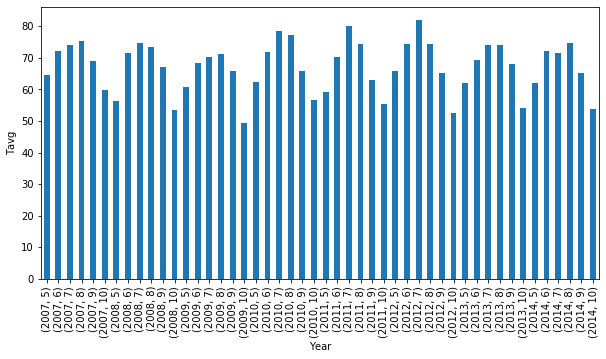

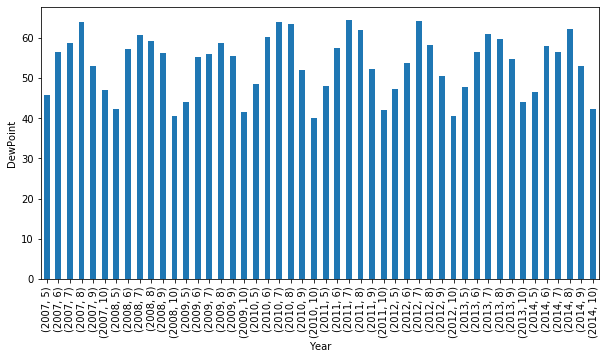

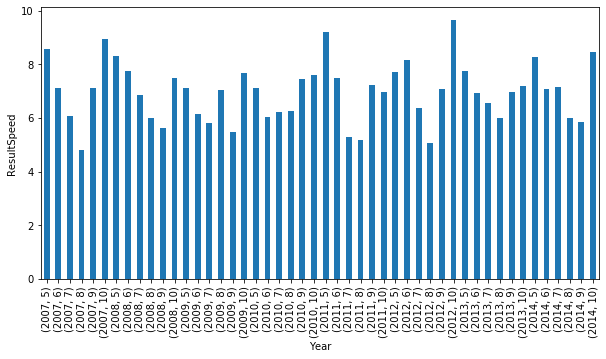

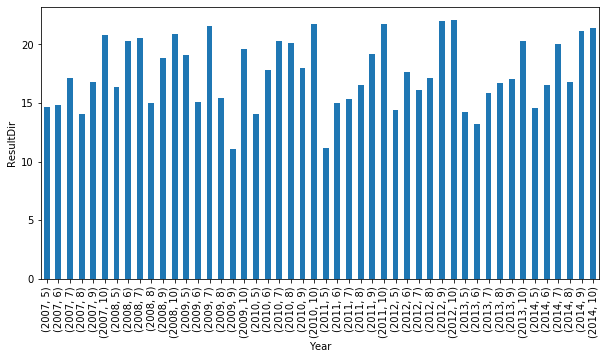

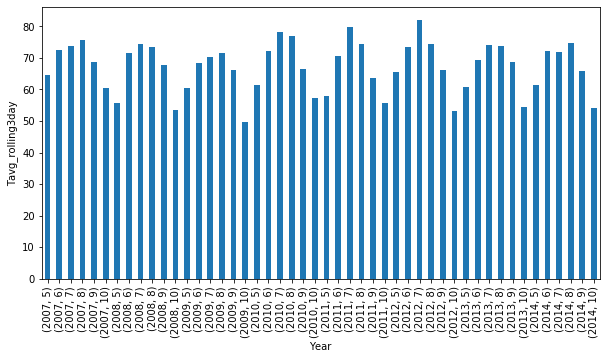

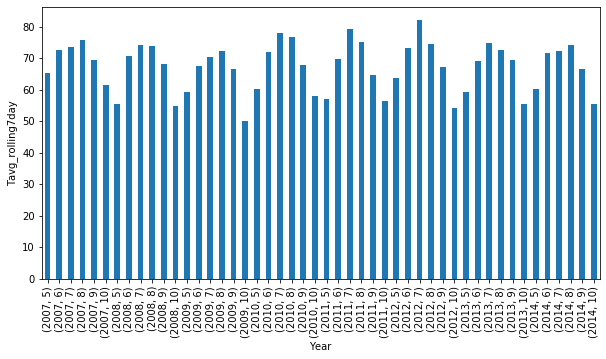

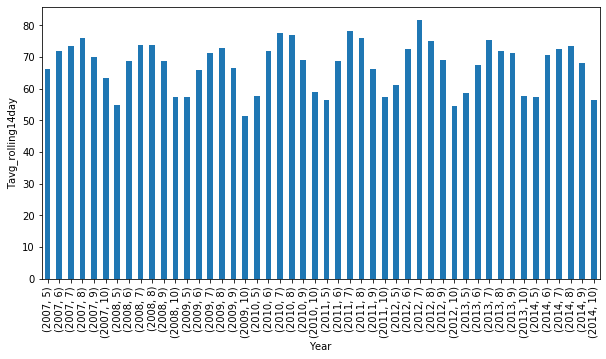

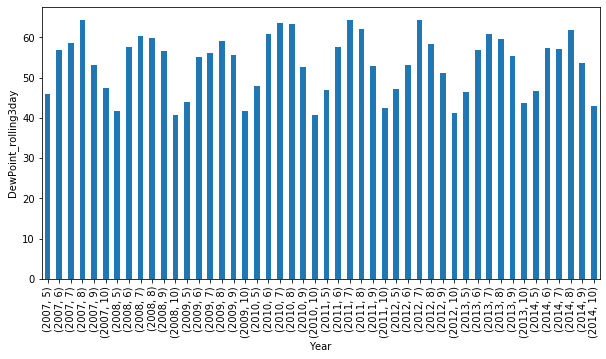

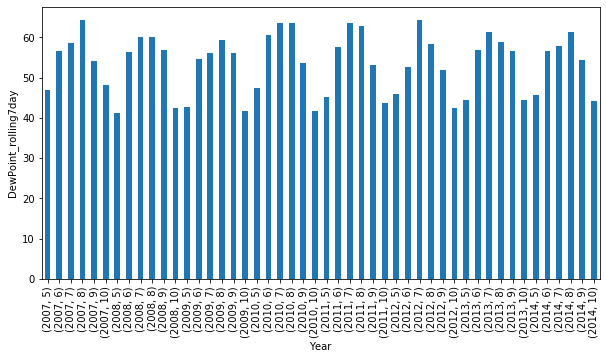

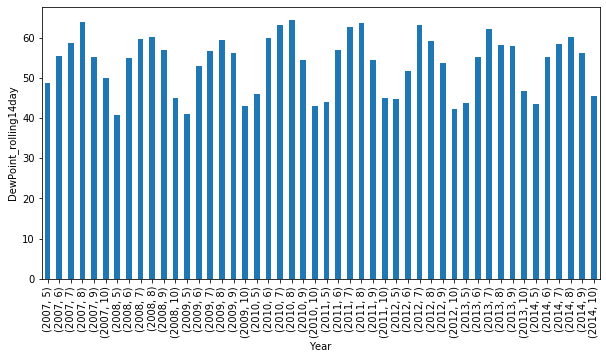

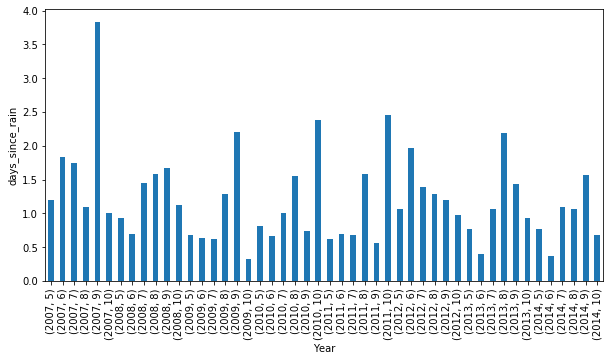

In [54]:
plot_weather_trend()

- There is clear seasonality for Tavg. In all years apart from 2014, temperatures peak in July and August
- For DewPoint, there is also a relatively clear seasonal aspect to it as well. July and August are for the most part the 2 most humid months of that year.
- The amount of rain varies a bit more compared to the other 2 features.

## 1.3 Spray dataset

In [55]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [56]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null object
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [57]:
# The 'Time' column can be dropped as it is too much granularity
# The other datasets do not have a 'Time' column and ultimately it is too much information
spray.drop(columns='Time', inplace=True)

In [58]:
# Convert 'Date' column to date-time
spray['Date'] = pd.to_datetime(spray['Date'])

In [59]:
# See the average number of locations sprayed in a given month across the 2011 and 2013
spray.groupby(spray['Date'].dt.month).count()['Latitude']

Date
7    3809
8    7988
9    3038
Name: Latitude, dtype: int64

- According to spray data, pesticide is spayed on in July, August and September
- This reflects the fact that the highest number of mosquitos with WNV are found in these months

In [60]:
# See the number of locations sprayed in a given year
spray.groupby(spray['Date'].dt.year).count()[['Latitude', 'Longitude']]

,Latitude,Longitude
Date,,
2011,2209,2209
2013,12626,12626


- In 2013, the number of locations with pesticide being sprayed is increased by approx. 6 times.
    - From 2209 locations in 2011, to 12626 locations in 2013

Text(0.5, 0, 'Year')

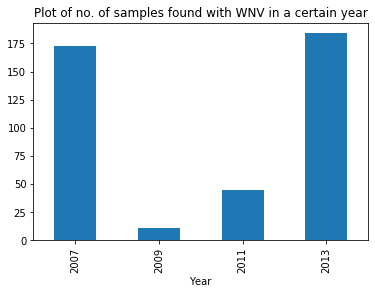

In [61]:
ax = training.groupby(train['Date'].dt.year).sum()['WnvPresent'].plot(kind='bar')
ax.set_title('Plot of no. of samples found with WNV in a certain year')
ax.set_xlabel('Year')

- In 2013, even though the amount of locations increased significantly, the number of mosquitos with WNV actually increased compared to 2011.
- Spraying data is given ony for 2011 and 2013

- **As there is no evident correlation between spraying and reduced WNV found in samples (since in 2013 the amount of sprayed locations was drastically increased, but the number of WNV carriers increased)**
- **the spray data will not be used.**


## 1.4 Preprocessing

- Scaling the data actually makes the ROC score worse, so data will not be scaled.

**Training dataset**

In [62]:
training.head()

,Date,Species,Latitude,Longitude,WnvPresent
7489,2011-08-26,CULEX TERRITANS,41.868077,-87.666901,0
9826,2013-08-22,CULEX PIPIENS/RESTUANS,41.659112,-87.538693,0
7809,2011-09-12,CULEX PIPIENS/RESTUANS,41.763733,-87.742302,0
3960,2009-06-02,CULEX RESTUANS,41.659112,-87.538693,0
6473,2011-07-11,CULEX PIPIENS/RESTUANS,41.932094,-87.700117,0


In [63]:
# Merge training dataset with weather data
final_training = pd.merge(training, weather, on='Date', how='left')

In [64]:
final_training.drop(columns=['Species'], inplace=True)

In [65]:
# Create final X & y training sets
features = [col for col in final_training.columns if (col != 'WnvPresent') & (col != 'Date')]
final_X_training = final_training[features]
final_y_training = final_training['WnvPresent']

In [66]:
# Scale data
#ss = StandardScaler()
#final_X_training = pd.DataFrame(ss.fit_transform(final_X_training), columns=final_X_training.columns)

In [67]:
# Perform SMOTE to deal with oversampling issue
# Initialize SMOTE
sm = SMOTE(random_state=55, ratio = 1.0)
final_X_training_sm, final_y_training_sm = sm.fit_sample(final_X_training, final_y_training)
final_X_training = pd.DataFrame(final_X_training_sm, columns=final_X_training.columns)
final_y_training = pd.DataFrame(final_y_training_sm, columns=['WnvPresent'])

In [68]:
final_y_training['WnvPresent'].value_counts()

1    7466
0    7466
Name: WnvPresent, dtype: int64

- Class is now balanced
- Baseline score is now 50%

In [69]:
#from google.colab import files

In [70]:
#final_X_training.to_csv('final_X_training.csv', index=False)
#files.download("final_X_training.csv")

#final_y_training.to_csv('final_y_training.csv', index=False)
#files.download("final_y_training.csv")

# Above code for use with Google collab
final_X_training.to_csv('./data/final_X_training.csv', index=False)
final_y_training.to_csv('./data/final_y_training.csv', index=False)

**Testing dataset**

In [71]:
#X_testing = pd.get_dummies(data=X_testing, columns=['Species'])
final_X_testing = pd.merge(X_testing, weather, on='Date', how='left')
final_X_testing.drop(columns=['Date', 'Species'], inplace=True)

In [72]:
# Scale data
#final_X_testing = pd.DataFrame(ss.transform(final_X_testing), columns=final_X_testing.columns)

In [73]:
final_X_testing.to_csv('./data/final_X_testing.csv', index=False)
#files.download("final_X_testing.csv")

y_testing.to_csv('./data/final_y_testing.csv', index=False)
#files.download("final_y_testing.csv")

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


**Test.csv**

In [74]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 5 columns):
Id           116293 non-null int64
Date         116293 non-null datetime64[ns]
Species      116293 non-null object
Latitude     116293 non-null float64
Longitude    116293 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 4.4+ MB


In [75]:
final_test = pd.merge(test, weather, on='Date', how='left')
#final_test =  pd.get_dummies(data=final_test, columns=['Species'])
final_test.drop(columns=['Date', 'Species'], inplace=True)
final_test.head()

,Id,Latitude,Longitude,Tavg,DewPoint,ResultSpeed,ResultDir,Tavg_rolling3day,Tavg_rolling7day,Tavg_rolling14day,DewPoint_rolling3day,DewPoint_rolling7day,DewPoint_rolling14day,days_since_rain
0,1,41.95469,-87.800991,75.0,55.5,9.15,18.0,71.5,74.785714,70.25,58.5,64.571429,58.607143,1
1,2,41.95469,-87.800991,75.0,55.5,9.15,18.0,71.5,74.785714,70.25,58.5,64.571429,58.607143,1
2,3,41.95469,-87.800991,75.0,55.5,9.15,18.0,71.5,74.785714,70.25,58.5,64.571429,58.607143,1
3,4,41.95469,-87.800991,75.0,55.5,9.15,18.0,71.5,74.785714,70.25,58.5,64.571429,58.607143,1
4,5,41.95469,-87.800991,75.0,55.5,9.15,18.0,71.5,74.785714,70.25,58.5,64.571429,58.607143,1


In [76]:
# Scale data
#features = [col for col in final_test.columns if col != 'Id']
#final_test_sc = pd.DataFrame(ss.transform(final_test[features]), columns=features)
#final_test = final_test[['Id']].join(final_test_sc, how='left')

In [77]:
final_test.to_csv('./data/final_test.csv', index=False)
#files.download("final_test.csv")

# 2. Map Visualization

In [78]:
# Load map data
mapdata = np.loadtxt("./data/mapdata_copyright_openstreetmap_contributors.txt")
traps = train[['Latitude', 'Longitude']]

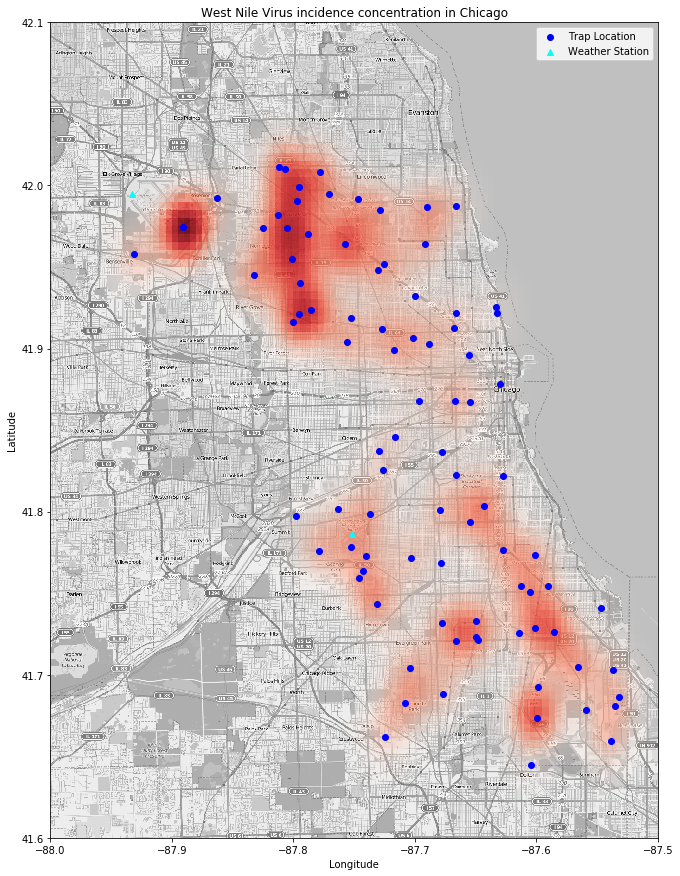

In [79]:
alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
trap_wnv = training[training['WnvPresent'] == 1] # Filter to get only WnvPresent == 1
trap_wnv = trap_wnv.groupby(['Date','Longitude', 'Latitude']).sum()['WnvPresent'].reset_index() # Groupby the cols, and sum incidences of WNV
X = trap_wnv[['Longitude', 'Latitude']].values
kd = KernelDensity(bandwidth=0.015) # Instantiate KernelDensity and fit to X
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density to show the hotspot of WNV areas
plt.figure(figsize=(15,15))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

#Trap locations
locations = trap_wnv[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='o', label='Trap Location', c='b')

# Weather locations
plt.scatter(x = (-87.933, -87.752), y = (41.995, 41.786), marker='^', color='cyan', label='Weather Station')

plt.title('West Nile Virus incidence concentration in Chicago')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('./img/map1.png')

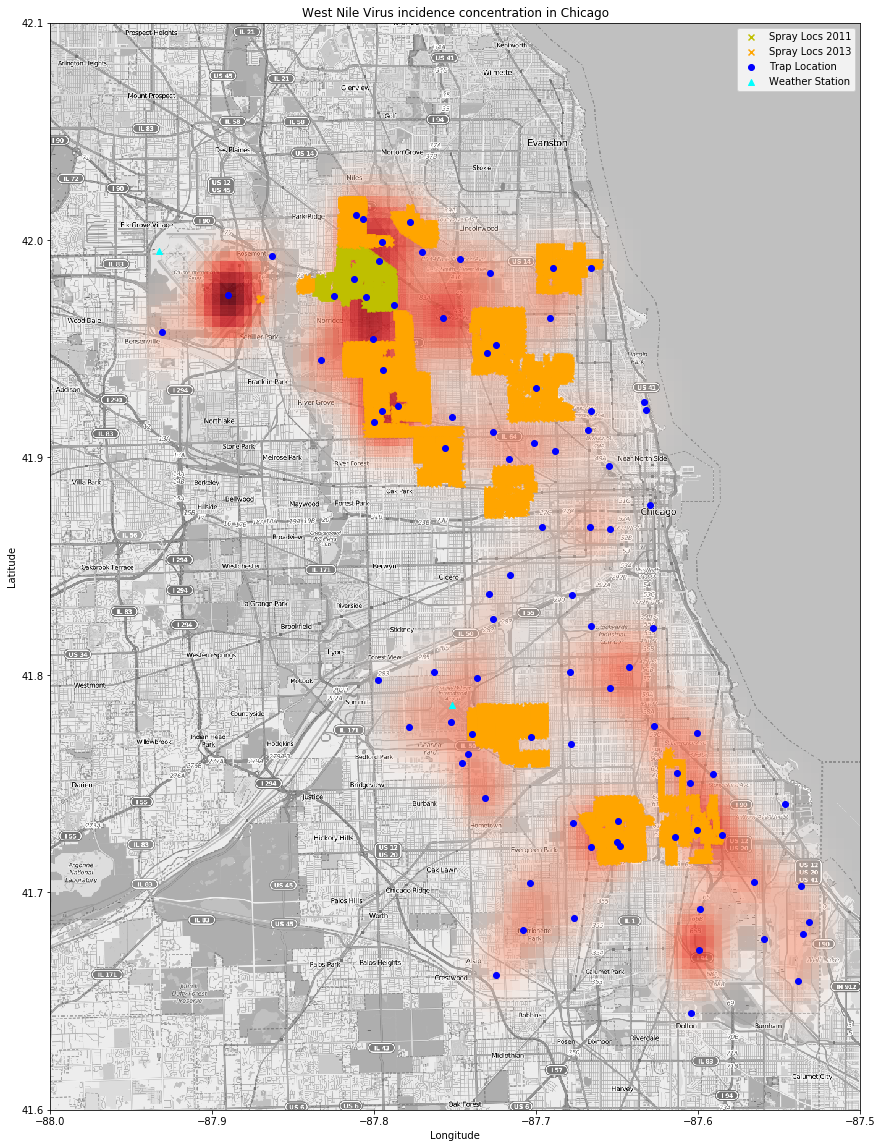

In [80]:
alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
trap_wnv = training[training['WnvPresent'] == 1] # Filter to get only WnvPresent == 1
trap_wnv = trap_wnv.groupby(['Date','Longitude', 'Latitude']).sum()['WnvPresent'].reset_index() # Groupby the cols, and sum incidences of WNV
X = trap_wnv[['Longitude', 'Latitude']].values
kd = KernelDensity(bandwidth=0.015) # Instantiate KernelDensity and fit to X
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density to show the hotspot of WNV areas
plt.figure(figsize=(20,20))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

#Spray locations
#For spray data in 2011, there is an area sprayed which was quite far away from all the traps
#Therefore that area will not be plotted
spray_locs_11 = spray[(spray['Date'].dt.year == 2011) & (spray['Latitude'] < 42.3)][['Longitude', 'Latitude']].drop_duplicates().values
spray_locs_13 = spray[spray['Date'].dt.year == 2013][['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(spray_locs_11[:,0], spray_locs_11[:,1], marker='x', label='Spray Locs 2011', c='y')
plt.scatter(spray_locs_13[:,0], spray_locs_13[:,1], marker='x', label='Spray Locs 2013', c='orange')

#Trap locations
locations = trap_wnv[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='o', label='Trap Location', c='b')

# Weather locations
plt.scatter(x = (-87.933, -87.752), y = (41.995, 41.786), marker='^', color='cyan', label='Weather Station')

plt.title('West Nile Virus incidence concentration in Chicago')
plt.legend(frameon=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('./img/map2.png')

- The areas with darker shades of red shows higher incidences of WNV samples.
    - One hotspot is at O'Hare airport
    - The other hotspot seems to be in the River Grove/Belmont Terrace area.


### 2.1 Cost Benefit Analysis of Spraying

- Mosquito killing services cost on average: USD 500 for 2000 m^2 (https://www.homeadvisor.com/cost/environmental-safety/mosquito-control/)


- O'Hare Airport (1 of the hotspots), spans 26,100,000 m^2 (https://www.pinkelephantparking.com/the-largest-airports-in-the-world/)
    - Spraying for O'Hare airport alone would cost approx. USD 6,525,000
    
    
- Plotting spray locations for 2011 reveals that in 2011 only a small area was sprayed. 
    - In 2013, the area covered significantly increased, however WNV incidences actually increased.
    - The rationale from the Chicago Dept. of Health was that spraying is an effective method to kill adult mosquitos and WNV carriers (https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2013/jul/city_to_spray_insecticidethursdaytokillmosquitoes.html)
    - However, the data suggests that is not so


- Therefore, it can be inferred that spraying does not really help.


- There is clear trend of increase in no. of WNV sampling incidence during the summer months of July & August.
    - During these months, the temperature and humidity increases, giving good conditions for mosquito breeding.
    - There is also an observed general trend of the number of days between rains.
        - This suggests higher probability for areas with still water, which is another important factor for mosquito breeding (https://www.hunker.com/13406498/how-to-kill-mosquito-larvae-in-standing-water-with-household-products)


- Since spraying is very expensive and data suggests that it is not effective, the most cost-efficient method is maybe to constantly educate the populace on ways to prevent an area from becoming a mosquito breeding ground.
    - Clean up puddles of water
    - Concentrate mosquito killing in the hotspots identified
        - Pesticides kill adult mosquitoes and do not kill larvae. The most effective way to kill larvae is to spray oil, but that is not possible for bodies of water with fish.
    - Monitor birds as they are carriers of WNV as well (https://en.wikipedia.org/wiki/West_Nile_virus)

# 3. Modelling

- Modelling is done in the main Modelling jupyter notebook called 'Model'
- Below is the selection of the best performing model based on Kaggle score (0.70)

### XGBoost

In [81]:
xgb = XGBClassifier()#n_estimators = 500)
xgb.fit(final_X_training, final_y_training)

C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [82]:
predicted = xgb.predict(final_X_training)
print("ROC score on training set: ", roc_auc_score(final_y_training, predicted).round(3))

ROC score on training set:  0.845


In [83]:
predicted = xgb.predict(final_X_testing)
print("ROC score on testing set: ", roc_auc_score(y_testing, predicted).round(3))

ROC score on testing set:  0.737


In [84]:
predproba_test = xgb.predict_proba(final_test.drop(columns=['Id']))

In [85]:
predproba_test

array([[0.3931616 , 0.6068384 ],
       [0.3931616 , 0.6068384 ],
       [0.3931616 , 0.6068384 ],
       ...,
       [0.99026644, 0.00973357],
       [0.99026644, 0.00973357],
       [0.99026644, 0.00973357]], dtype=float32)

In [86]:
predproba_test_df = pd.DataFrame(predproba_test, columns=['WnvAbsent', 'WnvPresent'])
predproba_test_df.head()

,WnvAbsent,WnvPresent
0,0.393162,0.606838
1,0.393162,0.606838
2,0.393162,0.606838
3,0.393162,0.606838
4,0.393162,0.606838


In [87]:
xgb_submit = pd.concat([final_test['Id'], predproba_test_df.iloc[:,1]], axis=1)
xgb_submit.to_csv('./data/xgb_submit.csv', index=False)

# 4. Conclusion

- Danger periods are during the summer months of Chicago, i.e. July and August
- Clear seasonality observed for weather data
- Spraying does not provide any benefits to justify the cost
- Maybe instead of focusing on mosquito surveillance, birds should be considered too as they are WNV carriers as well


**Limitations**
- Rather than sampling mosquito population and having a binary classification for WnvPresent, an improvement may be to show the number of mosquitos carrying WNV so that a rate can be calculated.
- Bird data is not given, which is quite important data as they are carriers as well.


**Further work**
- Usage of neural networks may provide an improvement to model performance.